# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [165]:
#Import all the required libraries

import numpy as np
import pandas as pd


import tensorflow as tf
import keras
from keras.preprocessing.image import load_img
import string
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from PIL import Image

#used for creating Progress Meters or Progress Bars
from tqdm import tqdm

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [166]:
import os
import kagglehub
import json

# Path to your config file
config_file = '/content/kaggle.json'

# Load JSON data from the file
with open(config_file, 'r') as file:
    config = json.load(file)

# Access the API key
user_name = config.get('username')
api_key = config.get('key')

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flickr8k


In [167]:
#Import the dataset and read the image into a seperate variable
import glob

image_dir='/kaggle/input/flickr8k/Images'

all_imgs = glob.glob(image_dir + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


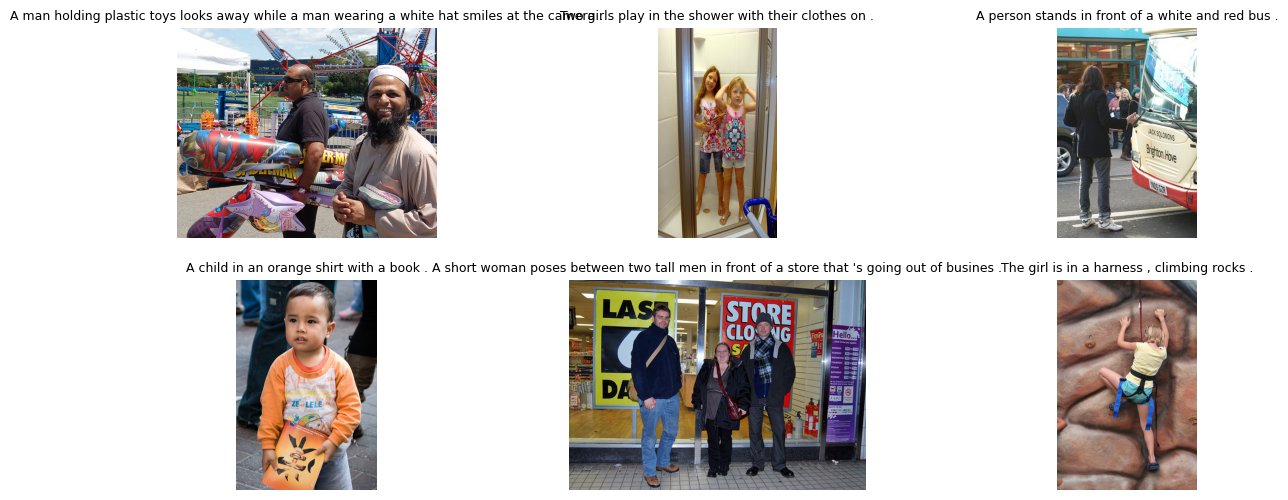

In [168]:
#Visualise both the images & text present in the dataset
from PIL import Image
import matplotlib.pyplot as plt

text_file = '/kaggle/input/flickr8k/captions.txt'

# --- Load labels from CSV ---
# --- Load labels properly ---
df = pd.read_csv(text_file, sep=',', names=['image', 'caption'], header=0)

# --- Limit how many samples you want to display ---
num_samples = 6
df = df.sample(n=num_samples).reset_index(drop=True)

# --- Plotting ---
plt.figure(figsize=(15, 6))

for idx, row in df.iterrows():
    img_path = os.path.join(image_dir, row['image'])

    try:
        image = Image.open(img_path)

        plt.subplot(2, 3, idx + 1)  # 2 rows, 3 columns for 6 images
        plt.imshow(image)
        plt.axis('off')
        plt.title(row['caption'], fontsize=9)
    except Exception as e:
        print(f"Could not open {img_path}: {e}")

plt.show()


In [169]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    #your code here
    with open(filename, 'r') as file:
        lines = file.readlines()[1:]  # Skip the first line (header)
        text = ''.join(lines)
    return text

doc = load_doc(text_file)
print(doc[:300])

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [170]:
all_img_id= []#store all the image id here
all_img_vector= []#store all the image path here
annotations= []#store all the captions here

# Process each line
for line in doc.strip().split('\n'):
    img_caption_pair = line.split(',', 1)  # split at the first comma only
    if len(img_caption_pair) != 2:
        continue  # skip malformed lines

    image_id, caption = img_caption_pair
    image_path = os.path.join(image_dir, image_id.strip())

    all_img_id.append(image_id.strip())
    all_img_vector.append(image_path)
    annotations.append(caption.strip())

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions'])

df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b0...,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,/kaggle/input/flickr8k/Images/997722733_0cb543...,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,/kaggle/input/flickr8k/Images/997722733_0cb543...,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,/kaggle/input/flickr8k/Images/997722733_0cb543...,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,/kaggle/input/flickr8k/Images/997722733_0cb543...,A rock climber in a red shirt .


In [171]:
#Create a list which contains all the captions

annotations= df['Captions'].tolist()

#add the <start> & <end> token to all those captions as well
annotations = [f"<start> {caption.strip()} <end>" for caption in annotations]

#Create a list which contains all the path to the images
all_img_path= df['Path'].tolist()

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [172]:
#Create the vocabulary & the counter for the captions
from collections import Counter

vocabulary= [word.lower() for line in annotations for word in line.split()]

val_count=Counter(vocabulary)
val_count

Counter({'<start>': 40455,
         'a': 61752,
         'child': 1535,
         'in': 18965,
         'pink': 735,
         'dress': 347,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 2399,
         'entry': 1,
         'way': 50,
         '.': 34212,
         '<end>': 40455,
         'girl': 3320,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 509,
         'little': 1754,
         'playhouse': 6,
         'the': 18249,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3825,
         'dog': 8126,
         'and': 8851,
         'spotted': 37,
         'are': 3504,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7761,
         'each': 430,
         'other': 772,
         'on': 10732,
         'road': 388,
         'white': 3935,
         'brown': 2549,
         

a :  61752
<start> :  40455
<end> :  40455
. :  34212
in :  18965
the :  18249
on :  10732
is :  9345
and :  8851
dog :  8126
with :  7761
man :  7238
of :  6712
two :  5224
white :  3935
black :  3825
boy :  3561
are :  3504
woman :  3385
girl :  3320
, :  3210
to :  3173
wearing :  3061
at :  2905
people :  2856
water :  2779
red :  2672
young :  2607
brown :  2549
an :  2399


Text(0, 0.5, 'Count')

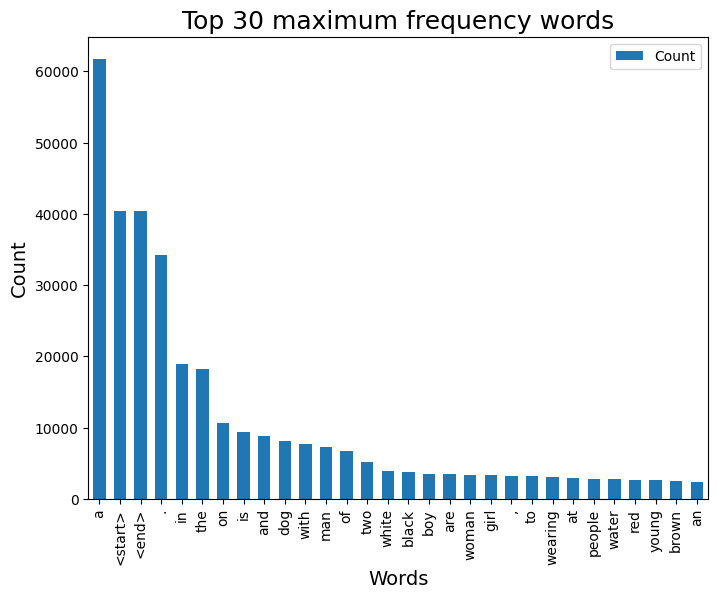

In [173]:
#Visualise the top 30 occuring words in the captions
import matplotlib.pyplot as plt

for word, count in val_count.most_common(30):
  print(word, ": ", count)

top_words = val_count.most_common(30)
most_common_words_df = pd.DataFrame(top_words, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word', y='Count', width=0.6, figsize=(8, 6))
plt.title("Top 30 maximum frequency words", fontsize = 18)
plt.xlabel("Words", fontsize = 14)
plt.ylabel("Count", fontsize = 14)

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters.
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [174]:
# create the tokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle

def tokenize(captions):
    special_chars = '`~"@#$%&()[]{}!*+=.,/:;?\^-_| '
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000+1, oov_token="UNK",filters=special_chars, lower = True, char_level = False)
    tokenizer.fit_on_texts(captions)

    return tokenizer


In [175]:
# Create word-to-index and index-to-word mappings.

img_captions, img_name_vector = shuffle(annotations, all_img_vector, random_state=42)
tokenizer = tokenize(img_captions)

#transform each text into a sequence of integers
train_seqs = tokenizer.texts_to_sequences(annotations)

Counter({'<start>': 40455, '<end>': 40455, 'a': 40271, '.': 34212, 'A': 21481, 'in': 18961, 'the': 15328, 'on': 10729, 'is': 9345, 'and': 8850, 'dog': 7982, 'with': 7760, 'man': 6828, 'of': 6712, 'Two': 3962, 'white': 3875, 'black': 3696, 'are': 3503, 'boy': 3442, 'woman': 3227, 'girl': 3217, ',': 3210, 'to': 3173, 'wearing': 3061, 'The': 2920, 'at': 2904, 'water': 2774, 'red': 2660, 'brown': 2475, 'people': 2442, 'young': 2431, '."': 2365, 'his': 2357, 'blue': 2257, 'dogs': 2082, 'running': 2072, 'through': 2031, 'playing': 2008, 'while': 1957, 'an': 1944, 'down': 1823, 'shirt': 1803, 'standing': 1786, 'ball': 1778, 'little': 1625, 'grass': 1621, 'snow': 1481, 'child': 1477, 'jumping': 1469, 'over': 1414, 'person': 1414, 'front': 1386, 'sitting': 1368, 'holding': 1324, 'field': 1276, 'two': 1262, 'up': 1260, 'by': 1248, 'green': 1218, 'small': 1207, 'yellow': 1207, 'large': 1191, '"A': 1186, 'her': 1178, 'group': 1172, 'walking': 1165, 'into': 1074, 'air': 1057, 'beach': 1044, 'men': 

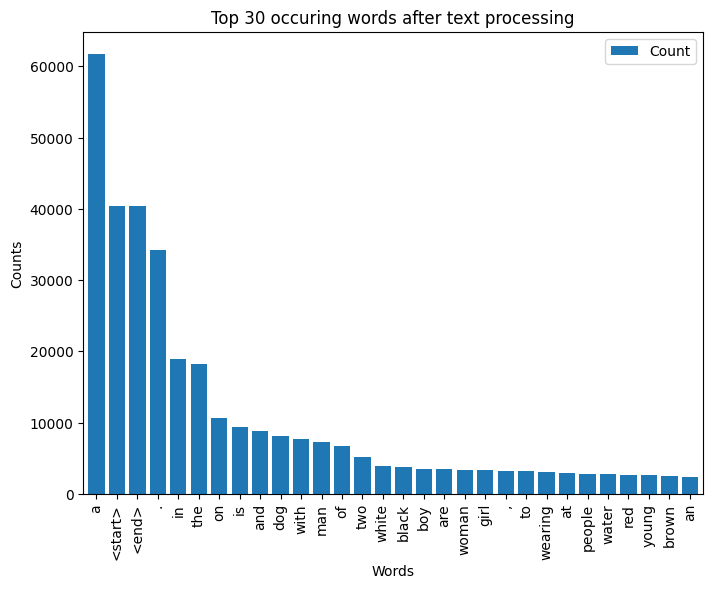

In [176]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

#your code here
import collections

tokenizer_top_words = [word for line in annotations for word in line.split() ]

#tokenizer_top_words_count
tokenizer_top_words_count = collections.Counter(tokenizer_top_words)
print(tokenizer_top_words_count)

tokens = tokenizer_top_words_count.most_common(30)
most_com_words_df = pd.DataFrame(tokens, columns = ['Word', 'Count'])
print(most_com_words_df.head())

#plot 30 most common words
most_common_words_df.plot.bar(x = 'Word', y= 'Count', width=0.8, figsize = (8, 6))
plt.title('Top 30 occuring words after text processing')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.show()

In [177]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

# we add PAD token for zero
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

#store the length of all lists
train_seqs_len = [len(seq) for seq in train_seqs]

#store elements from list with maximum value
longest_word_length = max(train_seqs_len)

#calculate longest word_length and pads all sequences to equal length as that of the longest.
cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding= 'post', maxlen = longest_word_length,
                                                          dtype='int32', value=0)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3.

In [178]:
img_shape = (299, 299)

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image.
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [179]:
#write your code here to create the dataset consisting of image paths

img_path_dataset = tf.data.Dataset.from_tensor_slices(all_img_vector)
img_path_dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [180]:
#write your code here for creating the function. This function should return images & their path

def load_image(image_path):
    #write your pre-processing steps here
    img = tf.io.read_file(image_path, name = None)
    img = tf.image.decode_jpeg(img, channels=3) #since these are RBG images
    img = tf.image.resize(img, img_shape)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [181]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path

# Apply the function to the dataset
image_dataset = img_path_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

#Check first few elements
for img, path in image_dataset.take(3):
    print("Image shape:", img.shape)
    print("Path:", path.numpy().decode())



Image shape: (299, 299, 3)
Path: /kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg
Image shape: (299, 299, 3)
Path: /kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg
Image shape: (299, 299, 3)
Path: /kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048.

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [182]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output#write code here to get the output of the image_model

image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

In [183]:
#Optional to save the extracted features
# for img_tensor, img_path in image_dataset:
#     # Expand dims and extract features
#     img_tensor = tf.expand_dims(img_tensor, axis=0)  # (1, 299, 299, 3)
#     features = image_features_extract_model(img_tensor)  # (1, 8, 8, 2048)
#     features = tf.reshape(features, (64, 2048))  # (64, 2048)

#     # Prepare filename and save
#     save_dir = 'features_inception'
#     os.makedirs(save_dir, exist_ok=True)
#     path_str = img_path.numpy().decode('utf-8')
#     filename = os.path.basename(path_str).split('.')[0] + '.npy'
#     filepath = os.path.join(save_dir, filename)
#     np.save(filepath, features.numpy())

In [184]:
# Directory to save features
save_dir = 'features_inc'
os.makedirs(save_dir, exist_ok=True)

# Batch the dataset for better GPU utilization
BATCH_SIZE = 64  # or 32 if GPU memory is limited
batched_dataset = image_dataset.batch(BATCH_SIZE)

# Iterate over batches
for batch_img_tensors, batch_img_paths in batched_dataset:
    # Extract features using the model (batch inference)
    batch_features = image_features_extract_model(batch_img_tensors)  # (batch, 8, 8, 2048)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], 64, 2048))  # (batch, 64, 2048)

    # Save features to disk
    for i in range(batch_features.shape[0]):
        path_str = batch_img_paths[i].numpy().decode('utf-8')
        filename = os.path.basename(path_str).split('.')[0] + '.npy'
        filepath = os.path.join(save_dir, filename)
        np.save(filepath, batch_features[i].numpy())

In [185]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
image_features_extract_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, None,      │        864 │ input_layer_1[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, None,      │      9,216 │ activation_94[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, None,      │     18,432 │ activation_95[0]… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, None,      │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, None,      │      5,120 │ max_pooling2d_4[… │
│                     │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, None,      │    138,240 │ activation_97[0]… │
│                     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, None,      │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature.

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [186]:
#write your code here
from sklearn.model_selection import train_test_split

path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector, cap_vector, test_size=0.2, random_state=42)

In [187]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [188]:
# Create a function which maps the image path to their feature.
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(img_path, caption):
    def load_feature(path):
        path_str = path.numpy().decode('utf-8')
        feature_path = os.path.join('features_inc', os.path.basename(path_str).split('.')[0] + '.npy')
        return np.load(feature_path).astype(np.float32)

    img_tensor = tf.py_function(load_feature, [img_path], tf.float32)
    img_tensor.set_shape((64, 2048))  # Ensure shape is set for downstream ops
    return img_tensor, caption

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [189]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def gen_dataset(img_paths, captions, batch_size=64, buffer_size=1000):

    # your code goes here to create the dataset & transform it
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, captions))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.map(map_func, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [190]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [191]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [192]:
BATCH_SIZE=64
embedding_dim = 256
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE #len(total train images) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE #len(total test images) // BATCH_SIZE

### Encoder

In [193]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = Dense(embed_dim, activation='relu')  # project 2048 → 256, building relu activation

    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)

        return features

In [194]:
encoder=Encoder(embedding_dim)

### Attention model

In [195]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = Dense(units) #build your Dense layer
        self.W2 = Dense(units) #build your Dense layer
        self.V = Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))  # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)  # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features  #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)  # reduce the shape to (batch_size, embedding_dim)

        return context_vector, attention_weights

### Decoder

In [289]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero =  False) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        self.dropout = tf.keras.layers.Dropout(0.5)


    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed =  self.dropout(self.embed(x)) # embed your input to shape: (batch_size, 1, embedding_dim)
        #mask = self.embed.compute_mask(x)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)

        #output,*state = self.gru(embed, mask = mask) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output,*state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)

        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output,state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [290]:
decoder =Decoder(embedding_dim, units, vocab_size)

In [291]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [292]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)  #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE) #define your loss object

In [293]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask #loss is getting multiplied with mask to get an ideal shape

    return tf.reduce_mean(loss_)

In [294]:
checkpoint_path = "Flickr8K/checkpoint1"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [296]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [331]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        encoder_op = encoder(img_tensor)

        #apply teacher forcing by passing target word as next input to the decoder
        for r in range(1, target.shape[1]) :
          #pass encoder_op to decoder
          predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
          loss = loss + loss_function(target[:, r], predictions)
          dec_input = tf.expand_dims(target[:, r], 1)

    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) # calculating gradient wrt each trainable var

    #we will now compute the gradients and apply it to the optimizer while backpropagating
    optimizer.apply_gradients(zip(grad, trainable_vars))

    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [332]:
@tf.function
def test_step(img_tensor, target):
    loss = 0

    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size = target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
      encoder_op = encoder(img_tensor)

      #apply teacher forcing again
      for r in range(1, target.shape[1]) :
        #pass encoder_op to decoder
        predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
        loss = loss + loss_function(target[:, r], predictions)

        dec_input = tf.expand_dims(target[: , r], 1)

    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) # calculating gradient wrt each trainable var

    #we will now compute the gradients and apply it to the optimizer while backpropagating
    optimizer.apply_gradients(zip(grad, trainable_vars))


    return loss, avg_loss

In [334]:
def test_loss_cal(test_dataset):
    total_loss = 0

    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps

    return avg_test_loss

In [335]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps

    loss_plot.append(avg_train_loss)
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)

    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]


OperatorNotAllowedInGraphError: in user code:

    File "<ipython-input-228-d777f3a1f845>", line 14, in train_step  *
        predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "<ipython-input-289-6785293f032c>", line 23, in call
        output,*state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)

    OperatorNotAllowedInGraphError: Exception encountered when calling GRU.call().
    
    [1mIterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.[0m
    
    Arguments received by GRU.call():
      • sequences=tf.Tensor(shape=(64, 1, 512), dtype=float32)
      • initial_state=None
      • mask=None
      • training=False


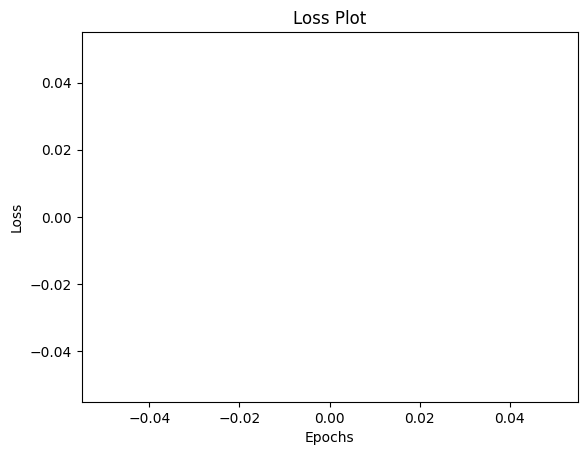

In [315]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE:
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not.
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model.

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [316]:
def evaluate(image):
    max_length = longest_word_length
    attention_features_shape=64
    attention_plot = np.zeros((max_length, attention_features_shape))

    # Replace decoder.reset_state with decoder.init_state
    hidden = decoder.reset_state(batch_size=1) # Use the reset_state method added to Decoder

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() #extract the predicted id(embedded value) which carries the max value
        #map the id to the word from tokenizer and append the value to the result list
        result.append (tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

### Beam Search(optional)

In [318]:
def beam_evaluate(image, beam_index = 3):

    #write your code to evaluate the result using beam search
    max_length=max_len
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)

                prob += np.log(predictions[0][w])

                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]


        predicted_id = result[-1]
        pred_list = predicted_id[0]

        prd_id = pred_list[-1]
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)
        else:
            break


    result2 = result[-1][0]

    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)

        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])

    return final_caption



In [319]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))

    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))

        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)

        img=ax.imshow(temp_img)

        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [320]:
from nltk.translate.bleu_score import sentence_bleu

In [321]:
def filt_text(text):
    filt=['<start>','<unk>','<end>']
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [322]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]
# test_image = './images/413231421_43833a11f5.jpg'
# real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)
pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)
print ('')
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)

AttributeError: 'Decoder' object has no attribute 'reset_state'

In [ ]:
captions=beam_evaluate(test_image)
print(captions)